## SA2 District Boundaries visualisation

    SA2_CODE21     SA2_NAME21 CHG_FLAG21  CHG_LBL21 SA3_CODE21 SA3_NAME21  \
644  201011001      Alfredton          0  No change      20101   Ballarat   
645  201011002       Ballarat          0  No change      20101   Ballarat   
646  201011005      Buninyong          0  No change      20101   Ballarat   
647  201011006      Delacombe          0  No change      20101   Ballarat   
648  201011007  Smythes Creek          0  No change      20101   Ballarat   

    SA4_CODE21 SA4_NAME21 GCC_CODE21    GCC_NAME21 STE_CODE21 STE_NAME21  \
644        201   Ballarat      2RVIC  Rest of Vic.          2   Victoria   
645        201   Ballarat      2RVIC  Rest of Vic.          2   Victoria   
646        201   Ballarat      2RVIC  Rest of Vic.          2   Victoria   
647        201   Ballarat      2RVIC  Rest of Vic.          2   Victoria   
648        201   Ballarat      2RVIC  Rest of Vic.          2   Victoria   

    AUS_CODE21 AUS_NAME21  AREASQKM21  \
644        AUS  Australia     52.7109  

<Axes: >

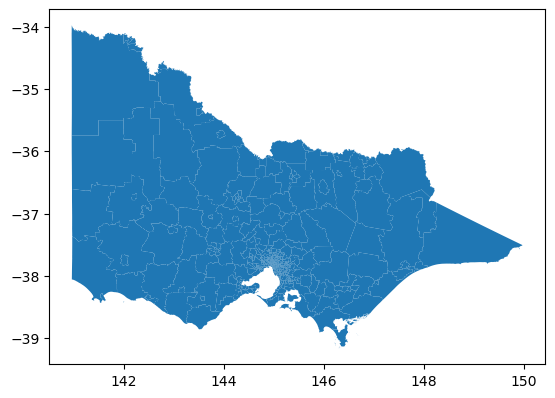

In [135]:
import geopandas as gpd
import folium
# Load the SA2 shapefile
gdf = gpd.read_file('../data/landing/SA2_Boundaries/SA2_2021_AUST_GDA2020.shp')
victoria_gdf = gdf[gdf['STE_NAME21'] == 'Victoria']
# Display the first few rows of the GeoDataFrame
print(victoria_gdf.head())

# Evaluate the structure of the shapefile
print(victoria_gdf.info())

# Optionally, you can visualize the geometries
victoria_gdf.plot()


## SA2 Total Population by SA2 Districts EDA

In [136]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import DataFrame
import numpy as np
import seaborn as sns
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("ads assigment 1 analysis")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.executor.memory", "16g") 
    .config("spark.driver.memory", "16g") 
    .config("spark.sql.shuffle.partitions", "200")  
    .config("spark.memory.fraction", "0.8")  
    .config("spark.memory.storageFraction", "0.2")
    .config("spark.executor.cores", "8") 
    .config("spark.driver.maxResultSize", "4g") 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

spark.sparkContext.setLogLevel("ERROR")

In [142]:
# reading in the excel and doing some format cleaning 
df_pop = pd.read_excel("../data/landing/sa2_total_population.xlsx", sheet_name="Table 2")
df_pop = df_pop.dropna() 
df_pop = df_pop.rename(columns=df_pop.iloc[0])
df_pop = df_pop.drop(df_pop.index[0]).reset_index(drop=True)
df_pop = df_pop[df_pop["GCCSA name"] == "Greater Melbourne"]
# dropping uneccessary columns
df_pop = df_pop.drop(columns=['GCCSA code', 'GCCSA name', 'SA4 code', 
                  'SA4 name', 'SA3 code', 'SA3 name'], axis=1)
# renaming columns
df_pop.columns = [
    'SA2_Code', 'SA2_Name', 'ERP_2022_no.', 'ERP_2023_no.', 'ERP_change_no.', 'ERP_change_Percentage',
    'pop_change_natural_increase', 'pop_change_net_internal_migration', 'pop_change_oversea_migration', 'Area_km2', 'population_Density_persons_per_km2_2023'
]
# converting the column names to lower case for easier access
df_pop.columns = df_pop.columns.str.lower()
df_pop.shape

(361, 11)

In [143]:
df_pop.head()

,sa2_code,sa2_name,erp_2022_no.,erp_2023_no.,erp_change_no.,erp_change_percentage,pop_change_natural_increase,pop_change_net_internal_migration,pop_change_oversea_migration,area_km2,population_density_persons_per_km2_2023
111,206011106,Brunswick East,13309,13765,456,3.4,84,-187,559,2.2,6348.6
112,206011107,Brunswick West,14697,15196,499,3.4,38,-114,575,3.2,4779.4
113,206011109,Pascoe Vale South,10420,10628,208,2,25,-9,192,3,3556.1
114,206011495,Brunswick - North,13266,14057,791,6,49,165,577,2.4,5835
115,206011496,Brunswick - South,13378,14273,895,6.7,64,166,665,2.7,5221.7


In [144]:
# Convert columns to numeric types where possible
for col in df_pop.columns:
    # Try to convert to numeric, setting errors='coerce' will convert invalid parsing to NaN
    if col == "sa2_name" or col == "sa2_code":
        continue
    else:
        df_pop[col] = pd.to_numeric(df_pop[col], errors='coerce')

df_pop.describe()


,erp_2022_no.,erp_2023_no.,erp_change_no.,erp_change_percentage,pop_change_natural_increase,pop_change_net_internal_migration,pop_change_oversea_migration,area_km2,population_density_persons_per_km2_2023
count,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000
mean,13960.279778,14424.224377,463.944598,3.220222,75.872576,-18.498615,406.570637,27.680609,2575.219114
std,5601.808382,5831.343856,569.144038,3.586604,104.120445,416.138353,417.665883,77.872636,3102.567938
min,0.000000,0.000000,-100.000000,-0.600000,-190.000000,-915.000000,0.000000,0.600000,0.000000
25%,10063.000000,10479.000000,156.000000,1.200000,18.000000,-177.000000,160.000000,4.200000,950.800000
50%,13427.000000,13915.000000,316.000000,2.200000,56.000000,-75.000000,307.000000,6.700000,2147.900000
75%,17990.000000,18326.000000,561.000000,3.700000,113.000000,0.000000,495.000000,13.400000,3066.500000
max,28727.000000,31976.000000,4299.000000,26.400000,722.000000,3443.000000,3722.000000,729.800000,38401.000000


In [145]:
top_10_suburbs = df_pop.sort_values(by='erp_change_percentage', ascending=False).head(10)
top_10_suburbs

,sa2_code,sa2_name,erp_2022_no.,erp_2023_no.,erp_change_no.,erp_change_percentage,pop_change_natural_increase,pop_change_net_internal_migration,pop_change_oversea_migration,area_km2,population_density_persons_per_km2_2023
430,213041574,Fraser Rise - Plumpton,12991,16420,3429,26.4,310,2987,132,58.7,279.6
448,213051584,Tarneit - North,9428,11213,1785,18.9,257,1360,168,14.3,781.7
392,212051567,Clayton (North) - Notting Hill,10735,12753,2018,18.8,-3,-228,2249,5.2,2438.8
422,213041359,Rockbank - Mount Cottrell,22960,27259,4299,18.7,637,3443,219,125.8,216.8
127,206041117,Carlton,18057,21376,3319,18.4,2,-405,3722,1.8,11753.5
446,213051582,Tarneit (West) - Mount Cottrell,13094,15293,2199,16.8,364,1609,226,36.7,416.6
135,206041503,Melbourne CBD - East,10687,12408,1721,16.1,27,-213,1907,0.8,15471.3
137,206041505,Melbourne CBD - West,17343,20027,2684,15.5,62,24,2598,1.0,19925.4
428,213041572,Cobblebank - Strathtulloh,8876,10248,1372,15.5,259,1006,107,19.8,518.6
364,212031556,Clyde North - South,18009,20688,2679,14.9,458,2039,182,19.7,1052.6


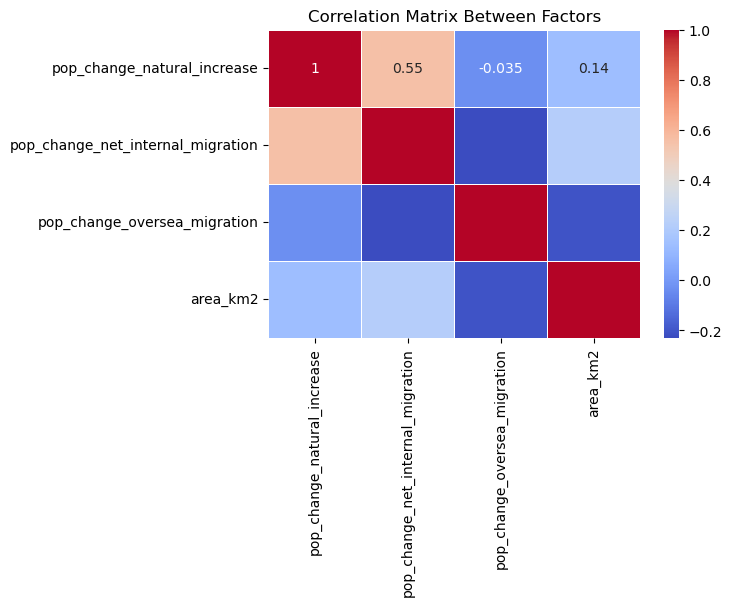

In [146]:
# Select the correlation we are interested in
columns_of_interest = ['pop_change_natural_increase', 'pop_change_net_internal_migration', 
                   'pop_change_oversea_migration', 'area_km2']

# Filter out the relevant numeric data
df_numeric = df_pop[columns_of_interest]

# Create the correlation matrix
corr_matrix = df_numeric.corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title('Correlation Matrix Between Factors')
plt.show()


Overseas migration is influenced by the size of the area: This could imply that larger areas (higher area_km2) tend to attract more overseas migrants. Bigger areas might have more resources, housing, or infrastructure that can accommodate a higher influx of international migrants, compared to areas with smaller populations or less space.

### Further Analysis
- connect with other datasets to analyse internal migration- why did people move around this helps to understand why a suburb might have attracted more internal migration (more liveable? more affordable?) 
- rental prices are based on demand too- with increase of migration rental price might go up (useful for predicting rental price)

## SA2 Population Forecast EDA

In [147]:
# extracting dataset from the excel file
df_dwellings_household = pd.read_excel("../data/landing/VIF2023_SA2_Pop_Hhold_Dwelling_Projections_to_2036_Release_2.xlsx", 
                                       sheet_name="Dwellings_and_Households")

In [148]:
df_dwellings_household = df_dwellings_household.dropna()
df_dwellings_household = df_dwellings_household.rename(columns=df_dwellings_household.iloc[0])
df_dwellings_household = df_dwellings_household.drop(df_dwellings_household.index[0]).reset_index(drop=True)
df_dwellings_household.drop(columns=['GCCSA', 'SA4 Code', 'SA3 Code', 'Region Type'], axis=1, inplace=True)
df_dwellings_household.head()

,SA2 code,Region,2021,2026.0,2031.0,2036.0,2021,2026.0,2031.0,2036.0,...,2031.0,2036.0,2021,2026.0,2031.0,2036.0,2021,2026.0,2031.0,2036.0
0,201011001,Alfredton,16841,20756.256163,23604.443836,26060.320807,114.520272,151.366762,172.315603,189.427293,...,2.575123,2.554885,6245,8252.000000,9732.000000,10830.000000,0.967833,0.935,0.935,0.935
1,201011002,Ballarat,12071,11698.293593,11803.430603,11985.992387,498.059374,528.553318,573.473458,619.865548,...,1.975963,1.937952,5970,6134.548371,6350.037451,6553.095884,0.90819,0.895,0.895,0.895
2,201011005,Buninyong,7229,7372.079773,7685.113372,8028.887243,186.410988,207.634905,238.375787,236.675013,...,2.475924,2.405964,2768,2943.325691,3199.637967,3445.433425,0.963041,0.940,0.940,0.940
3,201011006,Delacombe,10648,15915.186041,20475.587469,24965.202439,97.534756,176.721664,262.083648,323.597103,...,2.421662,2.395607,4172,6585.376102,8740.266903,10770.851234,0.984004,0.955,0.955,0.955
4,201011007,Smythes Creek,4211,4312.098530,4457.413406,4725.467837,0,0.000000,0.000000,0.000000,...,2.786580,2.737151,1490,1600.000000,1720.000000,1856.363636,0.959381,0.930,0.930,0.930


In [149]:
# renaming columns for dwellings and household
new_columns = ["SA2 code", "Region",
    "ERP_2021", "ERP_2026", "ERP_2031", "ERP_2036",
    "PNPD_2021", "PNPD_2026", "PNPD_2031", "PNPD_2036",
    "POPD_2021", "POPD_2026", "POPD_2031", "POPD_2036",
    "OPD_2021", "OPD_2026", "OPD_2031", "OPD_2036",
    "HHS_2021", "HHS_2026", "HHS_2031", "HHS_2036",
    "SPD_2021", "SPD_2026", "SPD_2031", "SPD_2036",
    "OCC_2021", "OCC_2026", "OCC_2031", "OCC_2036"
]

# Replace the current column names with the new ones
df_dwellings_household.columns = new_columns

In [150]:
df_dwellings_household.head()

,SA2 code,Region,ERP_2021,ERP_2026,ERP_2031,ERP_2036,PNPD_2021,PNPD_2026,PNPD_2031,PNPD_2036,...,HHS_2031,HHS_2036,SPD_2021,SPD_2026,SPD_2031,SPD_2036,OCC_2021,OCC_2026,OCC_2031,OCC_2036
0,201011001,Alfredton,16841,20756.256163,23604.443836,26060.320807,114.520272,151.366762,172.315603,189.427293,...,2.575123,2.554885,6245,8252.000000,9732.000000,10830.000000,0.967833,0.935,0.935,0.935
1,201011002,Ballarat,12071,11698.293593,11803.430603,11985.992387,498.059374,528.553318,573.473458,619.865548,...,1.975963,1.937952,5970,6134.548371,6350.037451,6553.095884,0.90819,0.895,0.895,0.895
2,201011005,Buninyong,7229,7372.079773,7685.113372,8028.887243,186.410988,207.634905,238.375787,236.675013,...,2.475924,2.405964,2768,2943.325691,3199.637967,3445.433425,0.963041,0.940,0.940,0.940
3,201011006,Delacombe,10648,15915.186041,20475.587469,24965.202439,97.534756,176.721664,262.083648,323.597103,...,2.421662,2.395607,4172,6585.376102,8740.266903,10770.851234,0.984004,0.955,0.955,0.955
4,201011007,Smythes Creek,4211,4312.098530,4457.413406,4725.467837,0,0.000000,0.000000,0.000000,...,2.786580,2.737151,1490,1600.000000,1720.000000,1856.363636,0.959381,0.930,0.930,0.930


In [151]:
df_dwellings_household.describe()

,ERP_2026,ERP_2031,ERP_2036,PNPD_2026,PNPD_2031,PNPD_2036,POPD_2026,POPD_2031,POPD_2036,OPD_2026,...,OPD_2036,HHS_2026,HHS_2031,HHS_2036,SPD_2026,SPD_2031,SPD_2036,OCC_2026,OCC_2031,OCC_2036
count,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,...,522.000000,522.000000,522.000000,522.000000,522.000000,522.00000,522.000000,522.000000,522.000000,522.000000
mean,13757.902733,14947.326532,16143.831949,200.988696,228.049307,258.373164,13556.914037,14719.277224,15885.458784,5429.086844,...,6439.716431,2.463303,2.442374,2.414996,5916.648408,6450.76752,7007.306146,0.902498,0.903844,0.903611
std,6846.805548,8376.370980,10262.113786,345.830817,374.863079,415.260018,6770.737724,8282.766795,10143.337890,2674.275118,...,3780.039887,0.532473,0.518969,0.512049,3009.413839,3493.52757,4136.809113,0.150954,0.145889,0.146078
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,8882.210406,9431.000281,10002.320987,21.904208,25.479017,28.482347,8768.985859,9389.571870,9747.974251,3495.538986,...,3868.050500,2.204886,2.174089,2.146582,3826.750000,4062.25000,4283.000000,0.910000,0.910000,0.910000
50%,13453.533601,14313.409408,14990.549727,118.402355,140.030247,158.012340,13284.243612,14091.176910,14716.762243,5248.235049,...,5982.965000,2.472626,2.457049,2.436822,5695.000000,6032.50000,6377.000000,0.940000,0.940000,0.940000
75%,17577.311609,19117.196877,20334.092930,248.869846,290.221051,332.400184,17406.048380,18848.538541,20039.497292,7042.180000,...,8236.884000,2.754757,2.723013,2.689763,7619.753716,8252.25000,8813.750000,0.960000,0.960000,0.960000
max,41470.660358,63590.269062,87876.000000,3913.891381,3985.367385,4426.492905,39177.089944,60250.592224,87436.620000,14148.120000,...,29616.580000,3.766443,3.732327,3.686169,20937.000000,21387.00000,30221.000000,0.990000,0.990000,0.990000


In [152]:
# Replace zero values with NaN to avoid division by zero
df_dwellings_household['ERP_2021'].replace(0, np.nan, inplace=True)
df_dwellings_household['ERP_2026'].replace(0, np.nan, inplace=True)
df_dwellings_household['ERP_2031'].replace(0, np.nan, inplace=True)

# Calculate percentage growth between years for each SA2 code
df_dwellings_household['population_growth_2021_2026'] = ((df_dwellings_household['ERP_2026'] - df_dwellings_household['ERP_2021']) 
                                                         / df_dwellings_household['ERP_2021']) * 100
df_dwellings_household['population_growth_2026_2031'] = ((df_dwellings_household['ERP_2031'] - df_dwellings_household['ERP_2026']) 
                                                         / df_dwellings_household['ERP_2026']) * 100
df_dwellings_household['population_growth_2031_2036'] = ((df_dwellings_household['ERP_2036'] - df_dwellings_household['ERP_2031']) 
                                                         / df_dwellings_household['ERP_2031']) * 100
df_dwellings_household['total_population_growth'] = (
    df_dwellings_household['population_growth_2021_2026'] +
    df_dwellings_household['population_growth_2026_2031'] +
    df_dwellings_household['population_growth_2031_2036']
)
# Check top 10 regions with the highest growth rate between 2021 and 2026
df_dwellings_household.sort_values(by='total_population_growth', ascending=False).head(10)


,SA2 code,Region,ERP_2021,ERP_2026,ERP_2031,ERP_2036,PNPD_2021,PNPD_2026,PNPD_2031,PNPD_2036,...,SPD_2031,SPD_2036,OCC_2021,OCC_2026,OCC_2031,OCC_2036,population_growth_2021_2026,population_growth_2026_2031,population_growth_2031_2036,total_population_growth
130,206041120,Flemington Racecourse,78.0,528.047097,1548.468219,2280.022356,0.263354,1.615456,4.739365,7.729171,...,938.0,1338.0,0.88,0.850,0.850,0.850,576.983457,193.244339,47.243729,817.471526
147,206051511,Port Melbourne Industrial,1944.0,12185.950084,23388.025585,35881.152847,0.832381,8.036538,15.640822,25.151463,...,11007.0,17507.0,0.903239,0.870,0.870,0.870,526.849284,91.926156,53.416768,672.192208
448,213051584,Tarneit - North,7340.0,19695.316016,29844.886865,38694.689839,0,0.000000,0.000000,0.000000,...,9915.0,12915.0,0.964632,0.960,0.960,0.960,168.328556,51.532917,29.652660,249.514134
430,213041574,Fraser Rise - Plumpton,10239.0,26194.793820,39244.571756,52294.465506,0,0.000000,0.000000,0.000000,...,13347.0,17847.0,0.991047,0.968,0.958,0.958,155.833517,49.818212,33.252736,238.904465
422,213041359,Rockbank - Mount Cottrell,17900.0,41470.660358,63590.269062,85990.068728,1046.931625,2293.570414,3339.676838,4426.492905,...,21305.0,29305.0,0.98,0.968,0.958,0.958,131.679667,53.337971,35.225200,220.242838
446,213051582,Tarneit (West) - Mount Cottrell,10316.0,22897.617978,33050.599206,43412.189415,0,0.000000,0.000000,0.000000,...,10996.0,14496.0,0.934578,0.940,0.940,0.940,121.962175,44.340775,31.350688,197.653638
247,209041225,Whittlesea,10763.0,22798.760413,34116.945679,45662.048240,194.42291,130.912131,281.517546,510.865745,...,12406.0,16486.0,0.971854,0.955,0.955,0.955,111.825331,49.643862,33.839789,195.308983
364,212031556,Clyde North - South,15038.0,31590.447658,49807.772360,63246.660220,0,0.000000,0.000000,0.000000,...,15504.0,20504.0,0.99,0.975,0.975,0.975,110.070805,57.667194,26.981508,194.719506
246,209041224,Wallan,22953.0,37126.000000,58876.000000,87876.000000,0,0.000000,78.000000,439.380000,...,19771.0,30221.0,0.972006,0.980,0.980,0.980,61.747920,58.584281,49.256064,169.588264
453,213051589,Wyndham Vale - North,9176.0,16850.903699,24970.573064,33090.368835,0,0.000000,0.000000,0.000000,...,8625.0,11425.0,0.94809,0.950,0.950,0.950,83.641060,48.185364,32.517459,164.343883


### Further Analysis
- analyze the most important factors (features) that affect rental prices. While your dataset may not directly contain rental price data, you can estimate important predictors that influence rental prices based on population growth, density, occupancy, etc.
- Help answer questions to livibility and affordability with the top growth suburbs
- in depth research (using K means too) on the top 10 suburb forecasts as above
- Household Size and Dwelling Occupancy Trends